In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D,Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant
import os
import sys


Using TensorFlow backend.


In [2]:
glove_file = r'C:\Users\user\Downloads\DeeplearningPy\Project___TXT\Spam-filter-for-Quora-questions-master\glove.6B/glove.6B.100d.txt'
Embedding_Dim = 100
Validation_Split =0.2


In [3]:
dataset = r'C:\Users\user\Downloads\DeeplearningPy\Project___TXT\Spam-filter-for-Quora-questions-master/train.csv'

In [4]:
data = pd.read_csv(dataset)

In [5]:
data

qid  \
0        00002165364db923c7e6   
1        000032939017120e6e44   
2        0000412ca6e4628ce2cf   
3        000042bf85aa498cd78e   
4        0000455dfa3e01eae3af   
...                       ...   
1306117  ffffcc4e2331aaf1e41e   
1306118  ffffd431801e5a2f4861   
1306119  ffffd48fb36b63db010c   
1306120  ffffec519fa37cf60c78   
1306121  ffffed09fedb5088744a   

                                             question_text  target  
0        How did Quebec nationalists see their province...       0  
1        Do you have an adopted dog, how would you enco...       0  
2        Why does velocity affect time? Does velocity a...       0  
3        How did Otto von Guericke used the Magdeburg h...       0  
4        Can I convert montra helicon D to a mountain b...       0  
...                                                    ...     ...  
1306117  What other technical skills do you need as a c...       0  
1306118  Does MS in ECE have good job prospects in USA ...       0  
1306119                          Is foam insulation toxic?       0  
1306120  How can one start a research project based on ...       0  
1306121  Who wins in a battle between a Wolverine and a...       0  

[1306122 rows x 3 columns]

In [6]:
data['question_text'][1]

'Do you have an adopted dog, how would you encourage people to adopt and not shop?'

In [7]:
data.drop(['qid'], axis=1, inplace=True)

In [8]:
data

question_text  target
0        How did Quebec nationalists see their province...       0
1        Do you have an adopted dog, how would you enco...       0
2        Why does velocity affect time? Does velocity a...       0
3        How did Otto von Guericke used the Magdeburg h...       0
4        Can I convert montra helicon D to a mountain b...       0
...                                                    ...     ...
1306117  What other technical skills do you need as a c...       0
1306118  Does MS in ECE have good job prospects in USA ...       0
1306119                          Is foam insulation toxic?       0
1306120  How can one start a research project based on ...       0
1306121  Who wins in a battle between a Wolverine and a...       0

[1306122 rows x 2 columns]

In [9]:
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [10]:
def clean_text(df):
    all_reviews = list()
    lines = df["question_text"].values.tolist()
    for text in lines:
        text = text.lower()
        
        pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        text = pattern.sub('', text)
        
        emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        text = emoji.sub(r'', text)
        
        text = re.sub(r"i'm", "i am", text)
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"she's", "she is", text)
        text = re.sub(r"that's", "that is", text)        
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"where's", "where is", text) 
        text = re.sub(r"\'ll", " will", text)  
        text = re.sub(r"\'ve", " have", text)  
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"don't", "do not", text)
        text = re.sub(r"did't", "did not", text)
        text = re.sub(r"can't", "can not", text)
        text = re.sub(r"it's", "it is", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"have't", "have not", text)
        
        text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)
        tokens = word_tokenize(text)
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        words = [word for word in stripped if word.isalpha()]
#         stop_words = set(stopwords.words("english"))
#         stop_words.discard("not")
#         words = [w for w in words if not w in stop_words]
        words = ' '.join(words)
        all_reviews.append(words)
    return all_reviews

all_reviews = clean_text(data)
all_reviews[0:20]

['how did quebec nationalists see their province as a nation in the',
 'do you have an adopted dog how would you encourage people to adopt and not shop',
 'why does velocity affect time does velocity affect space geometry',
 'how did otto von guericke used the magdeburg hemispheres',
 'can i convert montra helicon d to a mountain bike by just changing the tyres',
 'is gaza slowly becoming auschwitz dachau or treblinka for palestinians',
 'why does quora automatically ban conservative opinions when reported but does not do the same for liberal views',
 'is it crazy if i wash or wipe my groceries off germs are everywhere',
 'is there such a thing as dressing moderately and if so how is that different than dressing modestly',
 'is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved completely disregarding their feelingslives so you get to have something go your way and feel temporarily at ease how did things change',
 'what can you say a

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_reviews)
sequences = tokenizer.texts_to_sequences(all_reviews)

In [12]:
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

Found 217658 unique tokens.


In [13]:
#finding the max_elnth of the sequence
max_len = 0
i= 0 
for i in range(len(sequences)):
    if len(sequences[i]) > max_len:
        max_len = len(sequences[i])
        #print(max_len)
        #print(sequences[i])
print(max_len)
        
    

126


In [14]:
x_data = pad_sequences(sequences, maxlen=max_len)

In [15]:
x_data

array([[    0,     0,     0, ...,  1114,     6,     1],
       [    0,     0,     0, ...,    11,    27,  1792],
       [    0,     0,     0, ...,   356,   442,  5381],
       ...,
       [    0,     0,     0, ...,  7640, 11231,  2916],
       [    0,     0,     0, ...,    45,  3404,   428],
       [    0,     0,     0, ...,    11,     4, 21122]])

In [16]:
x_data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    9,   47, 6438, 7160,  155,   56, 5958,
         37,    4, 1114,    6,    1])

In [17]:
labels = to_categorical(np.asarray(data['target']))

In [18]:
labels.shape, x_data.shape

((1306122, 2), (1306122, 126))

In [19]:
labels[0]

array([1., 0.], dtype=float32)

In [20]:
x_data.shape[0]

1306122

In [21]:
# Split the data tran & validation set
indices = np.arange(x_data.shape[0])
np.random.shuffle(indices)

In [22]:
indices.shape,indices

((1306122,), array([158879, 119858, 689868, ..., 134838, 484023, 729797]))

In [23]:
x_data = x_data[indices]


In [24]:
x_data

array([[    0,     0,     0, ...,  2307,     6,   455],
       [    0,     0,     0, ...,  2056,     5, 13022],
       [    0,     0,     0, ...,     5,     1,  3109],
       ...,
       [    0,     0,     0, ...,    24,    61, 14072],
       [    0,     0,     0, ...,  4504,    26,  1860],
       [    0,     0,     0, ...,   171,    23, 16513]])

In [25]:
labels = labels[indices]
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [26]:
validation_samples = int(Validation_Split * x_data.shape[0])
print(validation_samples)

261224


In [27]:
x_train = x_data[:-validation_samples]
y_train = labels[:-validation_samples]
x_val = x_data[-validation_samples:]
y_val = labels[-validation_samples:]

In [28]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1044898, 126), (1044898, 2), (261224, 126), (261224, 2))

In [29]:
x_train

array([[    0,     0,     0, ...,  2307,     6,   455],
       [    0,     0,     0, ...,  2056,     5, 13022],
       [    0,     0,     0, ...,     5,     1,  3109],
       ...,
       [    0,     0,     0, ...,  2347,    13,  6404],
       [    0,     0,     0, ...,   222,     6,  4242],
       [    0,     0,     0, ...,   673,     5,  1162]])

In [30]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [31]:
# embedding layer
embeddings_index = {}
file = glove_file
file = open(file,encoding='utf8')

for line in file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
file.close()

print('Found %s word vectores.' % len(embeddings_index))


Found 400000 word vectores.


In [32]:
values[0]

'sandberger'

In [33]:
word

'sandberger'

In [34]:
values[1:]

['0.28365',
 '-0.6263',
 '-0.44351',
 '0.2177',
 '-0.087421',
 '-0.17062',
 '0.29266',
 '-0.024899',
 '0.26414',
 '-0.17023',
 '0.25817',
 '0.097484',
 '-0.33103',
 '-0.43859',
 '0.0095799',
 '0.095624',
 '-0.17777',
 '0.38886',
 '0.27151',
 '0.14742',
 '-0.43973',
 '-0.26588',
 '-0.024271',
 '0.27186',
 '-0.36761',
 '-0.24827',
 '-0.20815',
 '0.22128',
 '-0.044409',
 '0.021373',
 '0.24594',
 '0.26143',
 '0.29303',
 '0.13281',
 '0.082232',
 '-0.12869',
 '0.1622',
 '-0.22567',
 '-0.060348',
 '0.28703',
 '0.11381',
 '0.34839',
 '0.3419',
 '0.36996',
 '-0.13592',
 '0.0062694',
 '0.080317',
 '0.0036251',
 '0.43093',
 '0.01882',
 '0.31008',
 '0.16722',
 '0.074112',
 '-0.37745',
 '0.47363',
 '0.41284',
 '0.24471',
 '0.075965',
 '-0.51725',
 '-0.49481',
 '0.526',
 '-0.074645',
 '0.41434',
 '-0.1956',
 '-0.16544',
 '-0.045649',
 '-0.40153',
 '-0.13136',
 '-0.4672',
 '0.18825',
 '0.2612',
 '0.16854',
 '0.22615',
 '0.62992',
 '-0.1288',
 '0.055841',
 '0.01928',
 '0.024572',
 '0.46875',
 '0.2582'

In [35]:
coefs.shape, coefs

((100,), array([ 0.28365  , -0.6263   , -0.44351  ,  0.2177   , -0.087421 ,
        -0.17062  ,  0.29266  , -0.024899 ,  0.26414  , -0.17023  ,
         0.25817  ,  0.097484 , -0.33103  , -0.43859  ,  0.0095799,
         0.095624 , -0.17777  ,  0.38886  ,  0.27151  ,  0.14742  ,
        -0.43973  , -0.26588  , -0.024271 ,  0.27186  , -0.36761  ,
        -0.24827  , -0.20815  ,  0.22128  , -0.044409 ,  0.021373 ,
         0.24594  ,  0.26143  ,  0.29303  ,  0.13281  ,  0.082232 ,
        -0.12869  ,  0.1622   , -0.22567  , -0.060348 ,  0.28703  ,
         0.11381  ,  0.34839  ,  0.3419   ,  0.36996  , -0.13592  ,
         0.0062694,  0.080317 ,  0.0036251,  0.43093  ,  0.01882  ,
         0.31008  ,  0.16722  ,  0.074112 , -0.37745  ,  0.47363  ,
         0.41284  ,  0.24471  ,  0.075965 , -0.51725  , -0.49481  ,
         0.526    , -0.074645 ,  0.41434  , -0.1956   , -0.16544  ,
        -0.045649 , -0.40153  , -0.13136  , -0.4672   ,  0.18825  ,
         0.2612   ,  0.16854  ,  0.22615

In [36]:
word_index.items()

dict_items([('the', 1), ('what', 2), ('is', 3), ('a', 4), ('to', 5), ('in', 6), ('of', 7), ('i', 8), ('how', 9), ('do', 10), ('and', 11), ('are', 12), ('for', 13), ('you', 14), ('can', 15), ('why', 16), ('it', 17), ('my', 18), ('that', 19), ('have', 20), ('if', 21), ('with', 22), ('on', 23), ('or', 24), ('does', 25), ('be', 26), ('not', 27), ('from', 28), ('your', 29), ('an', 30), ('which', 31), ('should', 32), ('would', 33), ('when', 34), ('get', 35), ('best', 36), ('as', 37), ('s', 38), ('people', 39), ('some', 40), ('there', 41), ('will', 42), ('who', 43), ('like', 44), ('at', 45), ('about', 46), ('did', 47), ('they', 48), ('by', 49), ('was', 50), ('we', 51), ('any', 52), ('so', 53), ('good', 54), ('me', 55), ('their', 56), ('one', 57), ('am', 58), ('india', 59), ('has', 60), ('after', 61), ('most', 62), ('where', 63), ('make', 64), ('this', 65), ('but', 66), ('more', 67), ('all', 68), ('think', 69), ('many', 70), ('between', 71), ('than', 72), ('much', 73), ('time', 74), ('other', 

In [37]:
# At this point we can leverage our embedding_index dictionary and our word_index to compute our embedding matrix:
embedding_matrix = np.zeros((len(word_index) + 1, Embedding_Dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not foud in embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector
    

In [38]:
embedding_matrix.shape



(217659, 100)

In [39]:
# we load this embedding matrix into an embedding layer. Note that we set trainable=False to prevent the weights from being udated during training
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                           Embedding_Dim,
                           weights = [embedding_matrix],
                           input_length = max_len,
                           trainable = False)

In [40]:
# finally we can then buid a small 1D convenet to solve our classification problem:
Sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = embedding_layer(Sequence_input)
x = Conv1D(128, 5, activation = 'relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation = 'relu')(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(2, activation='sigmoid')(x)

model = Model(Sequence_input, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 126)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 126, 100)          21765900  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 122, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 128)           82048     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3278

In [41]:
model.compile(loss='binary_crossentropy',
             optimizer = 'adam',
             metrics = ['acc'])



In [42]:
history_glove = model.fit(x_train, y_train, validation_data=(x_val,y_val),
         epochs = 10, batch_size = 128)

# Start time 

Train on 1044898 samples, validate on 261224 samples
Epoch 1/10
1044898/1044898 [==============================] - 2039s 2ms/step - loss: 0.1342 - acc: 0.9498 - val_loss: 0.1265 - val_acc: 0.9524
Epoch 2/10
1044898/1044898 [==============================] - 2041s 2ms/step - loss: 0.1231 - acc: 0.9532 - val_loss: 0.1246 - val_acc: 0.9532
Epoch 3/10
1044898/1044898 [==============================] - 2468s 2ms/step - loss: 0.1179 - acc: 0.9550 - val_loss: 0.1241 - val_acc: 0.9539
Epoch 4/10
1044898/1044898 [==============================] - 40514s 39ms/step - loss: 0.1137 - acc: 0.9563 - val_loss: 0.1244 - val_acc: 0.9525
Epoch 5/10
1044898/1044898 [==============================] - 2291s 2ms/step - loss: 0.1096 - acc: 0.9579 - val_loss: 0.1235 - val_acc: 0.9536
Epoch 6/10
1044898/1044898 [==============================] - 2160s 2ms/step - loss: 0.1057 - acc: 0.9593 - val_loss: 0.1270 - val_acc: 0.9522
Epoch 7/10
1044898/1044898 [==============================] - 2177s 2ms/step - loss: 0.

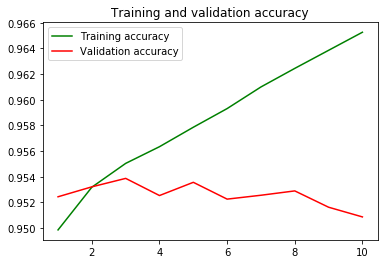

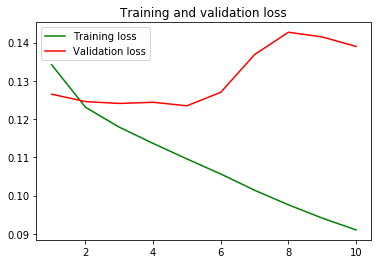

In [44]:
# Plot results
import matplotlib.pyplot as plt

acc = history_glove.history['acc']
val_acc = history_glove.history['val_acc']
loss = history_glove.history['loss']
val_loss = history_glove.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()